In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, recall_score, f1_score, precision_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,cross_validate, StratifiedKFold

from matplotlib import pyplot as plt
from keras.preprocessing import sequence
from gensim.models import Word2Vec

from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, LSTM

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

import re
import itertools
import pandas as pd
import numpy as np
import warnings
import eli5

%matplotlib inline

warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxkulagin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
mystem = Mystem() 
english_stopwords = stopwords.words("english")

def lemma_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in english_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

def preproc_text(array_text):
    new_array = []
    for text in array_text:
        new_text = lemma_text(text)
        new_array.append(new_text)
    return new_array

In [3]:
def plot_conf_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalize confusion matrix")
    else:
        print("Confusion matrix, without normalize")   
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("Истинное значение")
    plt.xlabel("Предсказанное значение")

In [4]:
def base_metrics(name, y_train, pred, pred_proba, save=False):
    print(name)
    print("Accuracy train =", accuracy_score(y_train, pred))
    print("Precision train =", precision_score(y_train, pred))
    print("Recall train =", recall_score(y_train, pred))
    print("F1_score train =", f1_score(y_train, pred))

    prs, rcl, thr = precision_recall_curve(y_train, pred_proba[:, 1])
    print("AUC_PR train =", auc(rcl, prs))
    fpr, tpr, thresholders = roc_curve(y_train, pred_proba[:, 1])
    print("AUC_ROC train =", auc(fpr, tpr))

    conf_matcatboost = confusion_matrix(y_train, pred)
    plt.figure(figsize=(10, 3))
    plot_conf_matrix(conf_matcatboost, classes=["Класс - 0", "Класс - 1"], title='Матрица ошибок '+name)
    if save==True:
        plt.savefig(name + "conf_matrix.png", dpi=300, bbox_inches='tight')

In [5]:
def roc_pr_data(model, x, y, graph='ROC'):
    pred_prob = model.predict_proba(x)
    if graph == 'ROC':
        fpr, tpr, thresholds = roc_curve(y, pred_prob[:,1])
        return fpr, tpr, thresholds
    elif graph == 'PR':
        prs, rcl, thresholds = precision_recall_curve(y, pred_prob[:,1])
        return prs, rcl, thresholds

# Data load and Preproc

In [6]:
data = pd.read_csv('../data/imdb_master.csv', encoding="ISO-8859-1")
# data = data.dropna()
data.head()

,id,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [70]:
data.label.value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

Text(0,0.5,'Количество примеров')

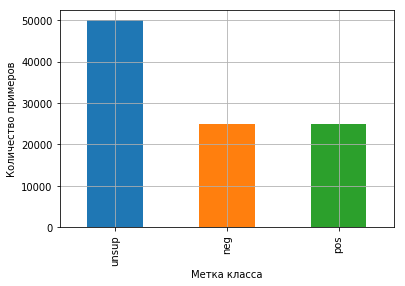

In [8]:
data.label.value_counts().plot.bar()
plt.grid(True)
plt.xlabel('Метка класса')
plt.ylabel('Количество примеров')
# plt.savefig('metka.png', dpi=300)

In [9]:
words = []
phrase = []
label = data.label.values
for a in data.review.values:
    reg_symbol = "()№.,!@#$\"\':;1234567890?^&*-=+-_/\\[]{}<>"
    for char in reg_symbol:
        a = a.replace(char," ")
    a = a.strip()
    a = re.sub(' +', ' ', a)
    phrase.append(a)
    subresult = []
    for word in a.split():
        if len(word) >= 1:
            subresult.append(word)
    words.append(subresult)

In [10]:
phrase[0]

'Once again Mr Costner has dragged out a movie for far longer than necessary Aside from the terrific sea rescue sequences of which there are very few I just did not care about any of the characters Most of us have ghosts in the closet and Costner s character are realized early on and then forgotten until much later by which time I did not care The character we should really care about is a very cocky overconfident Ashton Kutcher The problem is he comes off as kid who thinks he s better than anyone else around him and shows no signs of a cluttered closet His only obstacle appears to be winning over Costner Finally when we are well past the half way point of this stinker Costner tells us all about Kutcher s ghosts We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing No magic here it was all I could do to keep from turning it off an hour in'

In [11]:
# Lemmatization and Stopwords
new_phrase = preproc_text(phrase)

In [12]:
new_phrase[0]

'mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky overconfident ashton kutcher problem comes kid thinks better anyone else around shows signs cluttered closet obstacle appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior inkling foreshadowing magic could keep turning hour'

Text(0,0.5,'Число строк')

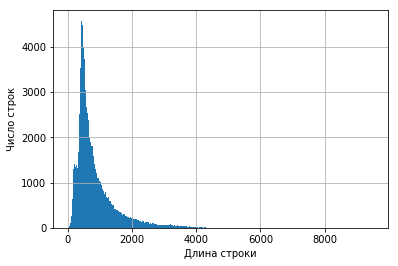

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(pd.Series(new_phrase).apply(lambda text: len(text)), bins='auto')
plt.grid(True)
plt.xlabel('Длина строки')
plt.ylabel('Число строк')
# plt.savefig('distr.png', dpi=300)

In [14]:
df = pd.concat([pd.Series(np.asarray(new_phrase)), pd.Series(label)], axis=1)
df.columns = ['reviews', 'label']
df_for_train = df[df.label != 'unsup']
df_for_test = df[df.label == 'unsup']
df_for_train['label'][df_for_train.label == 'neg'] = 0
df_for_train['label'][df_for_train.label == 'pos'] = 1
df_for_train.label = df_for_train.label.astype(int)

In [75]:
data.type[data.label != 'unsup'].value_counts()

test     25000
train    25000
Name: type, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_for_train.reviews, df_for_train.label, test_size=0.3)

In [71]:
X_train.shape, X_test.shape

((35000,), (15000,))

# Features extract + Train model

In [50]:
vecs = []
vecs.append(CountVectorizer(lowercase=True))
vecs.append(TfidfVectorizer())
vecs.append(TfidfVectorizer(ngram_range=(1,4)))

clfs = []
clfs.append(LogisticRegression())
clfs.append(KNeighborsClassifier(n_neighbors=10))
clfs.append(MLPClassifier(activation='logistic', epsilon=1e-05, verbose=True))
for classifier in clfs:
    
    for vectorizer in vecs:
        
        pipeline = Pipeline([
            ('vec', vectorizer),
            ('clf', classifier)
        ])
    
        print('---------------------------------')
        print(str(classifier))
        print(str(vectorizer))
        
        acc = cross_val_score(pipeline, X_train.values, y_train.values, cv=5)
        print('Accuracy', np.mean(acc), np.std(acc))

        recall = cross_val_score(pipeline, X_train.values, y_train.values, cv=5, scoring='recall')
        print('Recall', np.mean(recall), np.std(recall))

        precision = cross_val_score(pipeline, X_train.values, y_train.values, cv=5, scoring='precision')
        print('Precision', np.mean(precision), np.std(precision))

        f1 = cross_val_score(pipeline, X_train.values, y_train.values, cv=5, scoring='f1')
        print('F1', np.mean(f1), np.std(f1))
        print('-----------------------------------')

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Accuracy 0.8820855582169065 0.0027077123337776805
Recall 0.8881475651631104 0.0028159090132975828
Precision 0.8780028221133305 0.003919579690908353
F1 0.8830402298878008 0.002566419836902661
-----------------------------------
---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_inter

Iteration 18, loss = 0.00786285
Iteration 19, loss = 0.00701444
Iteration 20, loss = 0.00636667
Iteration 21, loss = 0.00582970
Iteration 22, loss = 0.00538159
Iteration 23, loss = 0.00500169
Iteration 24, loss = 0.00469652
Iteration 25, loss = 0.00443443
Iteration 26, loss = 0.00420377
Iteration 27, loss = 0.00401409
Iteration 28, loss = 0.00384584
Iteration 29, loss = 0.00369228
Iteration 30, loss = 0.00356343
Iteration 31, loss = 0.00344960
Iteration 32, loss = 0.00334392
Iteration 33, loss = 0.00325008
Iteration 34, loss = 0.00316771
Iteration 35, loss = 0.00308817
Iteration 36, loss = 0.00302067
Iteration 37, loss = 0.00295922
Iteration 38, loss = 0.00289531
Iteration 39, loss = 0.00284065
Iteration 40, loss = 0.00278938
Iteration 41, loss = 0.00274121
Iteration 42, loss = 0.00269537
Iteration 43, loss = 0.00265226
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.47304904
Iteration 2, loss = 0.25808686
Iteration 3, los

Iteration 42, loss = 0.00254691
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.47407340
Iteration 2, loss = 0.25988613
Iteration 3, loss = 0.18183855
Iteration 4, loss = 0.13349704
Iteration 5, loss = 0.09971667
Iteration 6, loss = 0.07545556
Iteration 7, loss = 0.05749229
Iteration 8, loss = 0.04385853
Iteration 9, loss = 0.03357918
Iteration 10, loss = 0.02656310
Iteration 11, loss = 0.02122995
Iteration 12, loss = 0.01739331
Iteration 13, loss = 0.01437020
Iteration 14, loss = 0.01204664
Iteration 15, loss = 0.01024743
Iteration 16, loss = 0.00888451
Iteration 17, loss = 0.00778715
Iteration 18, loss = 0.00694000
Iteration 19, loss = 0.00630520
Iteration 20, loss = 0.00570763
Iteration 21, loss = 0.00524983
Iteration 22, loss = 0.00487342
Iteration 23, loss = 0.00456236
Iteration 24, loss = 0.00428924
Iteration 25, loss = 0.00407143
Iteration 26, loss = 0.00386575
Iteration 27, loss = 0.00369315
Iteration 28, loss = 0.

Iteration 20, loss = 0.00576937
Iteration 21, loss = 0.00531008
Iteration 22, loss = 0.00491641
Iteration 23, loss = 0.00460185
Iteration 24, loss = 0.00433863
Iteration 25, loss = 0.00410107
Iteration 26, loss = 0.00389923
Iteration 27, loss = 0.00372870
Iteration 28, loss = 0.00357218
Iteration 29, loss = 0.00344907
Iteration 30, loss = 0.00333146
Iteration 31, loss = 0.00322472
Iteration 32, loss = 0.00313238
Iteration 33, loss = 0.00304944
Iteration 34, loss = 0.00297470
Iteration 35, loss = 0.00290319
Iteration 36, loss = 0.00284170
Iteration 37, loss = 0.00278232
Iteration 38, loss = 0.00273016
Iteration 39, loss = 0.00267796
Iteration 40, loss = 0.00263119
Iteration 41, loss = 0.00258781
Iteration 42, loss = 0.00254620
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.48055780
Iteration 2, loss = 0.26316994
Iteration 3, loss = 0.18420262
Iteration 4, loss = 0.13568849
Iteration 5, loss = 0.10184404
Iteration 6, loss =

Iteration 1, loss = 0.50443364
Iteration 2, loss = 0.27716650
Iteration 3, loss = 0.19453730
Iteration 4, loss = 0.14465773
Iteration 5, loss = 0.11013658
Iteration 6, loss = 0.08437650
Iteration 7, loss = 0.06512176
Iteration 8, loss = 0.05053514
Iteration 9, loss = 0.03948010
Iteration 10, loss = 0.03138582
Iteration 11, loss = 0.02547328
Iteration 12, loss = 0.02093934
Iteration 13, loss = 0.01741194
Iteration 14, loss = 0.01468599
Iteration 15, loss = 0.01246182
Iteration 16, loss = 0.01076936
Iteration 17, loss = 0.00938274
Iteration 18, loss = 0.00822774
Iteration 19, loss = 0.00737614
Iteration 20, loss = 0.00666385
Iteration 21, loss = 0.00609060
Iteration 22, loss = 0.00560801
Iteration 23, loss = 0.00523435
Iteration 24, loss = 0.00489851
Iteration 25, loss = 0.00461757
Iteration 26, loss = 0.00438010
Iteration 27, loss = 0.00417324
Iteration 28, loss = 0.00399109
Iteration 29, loss = 0.00383718
Iteration 30, loss = 0.00369424
Iteration 31, loss = 0.00357638
Iteration 32, los

Iteration 9, loss = 0.22486269
Iteration 10, loss = 0.20265955
Iteration 11, loss = 0.18415348
Iteration 12, loss = 0.16775324
Iteration 13, loss = 0.15372183
Iteration 14, loss = 0.14078160
Iteration 15, loss = 0.12939257
Iteration 16, loss = 0.11872814
Iteration 17, loss = 0.10922368
Iteration 18, loss = 0.10046040
Iteration 19, loss = 0.09235240
Iteration 20, loss = 0.08523222
Iteration 21, loss = 0.07855470
Iteration 22, loss = 0.07254366
Iteration 23, loss = 0.06690561
Iteration 24, loss = 0.06199014
Iteration 25, loss = 0.05746664
Iteration 26, loss = 0.05320751
Iteration 27, loss = 0.04952472
Iteration 28, loss = 0.04617702
Iteration 29, loss = 0.04312532
Iteration 30, loss = 0.04037105
Iteration 31, loss = 0.03789125
Iteration 32, loss = 0.03568284
Iteration 33, loss = 0.03357378
Iteration 34, loss = 0.03180206
Iteration 35, loss = 0.03010068
Iteration 36, loss = 0.02863066
Iteration 37, loss = 0.02723856
Iteration 38, loss = 0.02603766
Iteration 39, loss = 0.02489560
Iteration

Iteration 44, loss = 0.02148035
Iteration 45, loss = 0.02076103
Iteration 46, loss = 0.02010021
Iteration 47, loss = 0.01952717
Iteration 48, loss = 0.01896034
Iteration 49, loss = 0.01843996
Iteration 50, loss = 0.01795017
Iteration 51, loss = 0.01751212
Iteration 52, loss = 0.01710966
Iteration 53, loss = 0.01671354
Iteration 54, loss = 0.01636556
Iteration 55, loss = 0.01602330
Iteration 56, loss = 0.01571471
Iteration 57, loss = 0.01541019
Iteration 58, loss = 0.01512821
Iteration 59, loss = 0.01486075
Iteration 60, loss = 0.01460254
Iteration 61, loss = 0.01436962
Iteration 62, loss = 0.01413873
Iteration 63, loss = 0.01391212
Iteration 64, loss = 0.01369833
Iteration 65, loss = 0.01349894
Iteration 66, loss = 0.01330223
Iteration 67, loss = 0.01311630
Iteration 68, loss = 0.01293369
Iteration 69, loss = 0.01275255
Iteration 70, loss = 0.01258026
Iteration 71, loss = 0.01241392
Iteration 72, loss = 0.01225199
Iteration 73, loss = 0.01209617
Iteration 74, loss = 0.01194149
Iteratio

Iteration 58, loss = 0.01507565
Iteration 59, loss = 0.01480207
Iteration 60, loss = 0.01455211
Iteration 61, loss = 0.01431220
Iteration 62, loss = 0.01408692
Iteration 63, loss = 0.01386646
Iteration 64, loss = 0.01365975
Iteration 65, loss = 0.01345691
Iteration 66, loss = 0.01326166
Iteration 67, loss = 0.01307272
Iteration 68, loss = 0.01289329
Iteration 69, loss = 0.01271557
Iteration 70, loss = 0.01254698
Iteration 71, loss = 0.01237742
Iteration 72, loss = 0.01221998
Iteration 73, loss = 0.01206466
Iteration 74, loss = 0.01190912
Iteration 75, loss = 0.01175973
Iteration 76, loss = 0.01161370
Iteration 77, loss = 0.01146930
Iteration 78, loss = 0.01133058
Iteration 79, loss = 0.01119248
Iteration 80, loss = 0.01106192
Iteration 81, loss = 0.01092867
Iteration 82, loss = 0.01079916
Iteration 83, loss = 0.01067335
Iteration 84, loss = 0.01054788
Iteration 85, loss = 0.01042546
Iteration 86, loss = 0.01030361
Iteration 87, loss = 0.01018651
Iteration 88, loss = 0.01007078
Iteratio

Iteration 92, loss = 0.00950765
Iteration 93, loss = 0.00940111
Iteration 94, loss = 0.00929650
Iteration 95, loss = 0.00919523
Iteration 96, loss = 0.00909231
Iteration 97, loss = 0.00899020
Iteration 98, loss = 0.00889169
Iteration 99, loss = 0.00879492
Iteration 100, loss = 0.00869860
Iteration 101, loss = 0.00860352
Iteration 102, loss = 0.00850929
Iteration 103, loss = 0.00841848
Iteration 104, loss = 0.00832608
Iteration 105, loss = 0.00823627
Iteration 106, loss = 0.00814815
Iteration 107, loss = 0.00806033
Iteration 108, loss = 0.00797257
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.68519848
Iteration 2, loss = 0.65374867
Iteration 3, loss = 0.59150584
Iteration 4, loss = 0.49855832
Iteration 5, loss = 0.40754978
Iteration 6, loss = 0.33858293
Iteration 7, loss = 0.28977310
Iteration 8, loss = 0.25424396
Iteration 9, loss = 0.22643524
Iteration 10, loss = 0.20447029
Iteration 11, loss = 0.18571758
Iteration 12, 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-da4db105444e>", line 29, in <module>
    precision = cross_val_score(pipeline, X_train.values, y_train.values, cv=5, scoring='precision')
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 402, in cross_val_score
    error_score=error_score)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 240, in cross_validate
    for train, test in cv.split(X, y, groups))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 983, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Library/Frameworks

KeyboardInterrupt: 

# CNN

In [21]:
from collections import Counter

words_counter = Counter((word for text in X_train for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 1:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 87174


In [79]:
word2idx

{'': 0,
 '<unk>': 1,
 'br': 2,
 'movie': 3,
 'film': 4,
 'one': 5,
 'like': 6,
 'good': 7,
 'time': 8,
 'even': 9,
 'would': 10,
 'really': 11,
 'story': 12,
 'see': 13,
 'well': 14,
 'much': 15,
 'get': 16,
 'bad': 17,
 'people': 18,
 'great': 19,
 'also': 20,
 'first': 21,
 'made': 22,
 'make': 23,
 'way': 24,
 'could': 25,
 'movies': 26,
 'characters': 27,
 'think': 28,
 'character': 29,
 'watch': 30,
 'films': 31,
 'two': 32,
 'many': 33,
 'seen': 34,
 'love': 35,
 'acting': 36,
 'plot': 37,
 'never': 38,
 'life': 39,
 'best': 40,
 'know': 41,
 'show': 42,
 'little': 43,
 'ever': 44,
 'man': 45,
 'better': 46,
 'end': 47,
 'scene': 48,
 'still': 49,
 'say': 50,
 'scenes': 51,
 'something': 52,
 'go': 53,
 'back': 54,
 'real': 55,
 'thing': 56,
 'watching': 57,
 'actors': 58,
 'funny': 59,
 'though': 60,
 'old': 61,
 'director': 62,
 'another': 63,
 'years': 64,
 'actually': 65,
 'work': 66,
 'makes': 67,
 'look': 68,
 'nothing': 69,
 'new': 70,
 'find': 71,
 'going': 72,
 'lot': 73

In [28]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    for i in range(len(texts)):
        string = texts[i].split()
        for j in range(len(string)):
            if string[j] in word2idx:
                data[i,j] = word2idx[string[j]]
    return data

X_train_convert = convert(X_train.values, word2idx, 3000)

In [77]:
X_train_convert[:5]

array([[  119,    41,    34, ...,     0,     0,     0],
       [  275,    13, 10173, ...,     0,     0,     0],
       [ 4976,  7324, 23389, ...,     0,     0,     0],
       [    4,  1190, 12477, ...,     0,     0,     0],
       [ 1548,  1766,  9512, ...,     0,     0,     0]])

In [84]:
y_train_cv.shape

(23334,)

In [89]:
model = Sequential([
        Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train_cv.shape[1],)),
        Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', strides=1),
        GlobalMaxPooling1D(),
        Dense(units=1, activation='sigmoid')
    ])

model.summary()
# model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
# model.fit(X_train_cv, y_train_cv, batch_size=256, epochs=3, 
#               validation_data=(X_test_cv, y_test_cv))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 3000, 64)          5579136   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3000, 128)         24704     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 5,603,969
Trainable params: 5,603,969
Non-trainable params: 0
_________________________________________________________________


In [40]:
skf = StratifiedKFold(n_splits=3, shuffle=True)
arr_models = []
for train_index, test_index in skf.split(X_train_convert, y_train.values):
    X_train_cv, X_test_cv = X_train_convert[train_index], X_train_convert[test_index]
    y_train_cv, y_test_cv = y_train.values[train_index], y_train.values[test_index]
    model = Sequential([
        Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train_cv.shape[1],)),
        Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1),
        GlobalMaxPooling1D(),
        Dense(units=1, activation='sigmoid')
    ])

    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(X_train_cv, y_train_cv, batch_size=256, epochs=3, 
              validation_data=(X_test_cv, y_test_cv))
    arr_models.append(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3000, 64)          5579136   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2998, 128)         24704     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 5,603,969
Trainable params: 5,603,969
Non-trainable params: 0
_________________________________________________________________
Train on 23333 samples, validate on 11667 samples
Epoch 1/3
23333/23333 [==============================] - 656s 28ms/step - loss: 0.6025 - acc: 0.7145 - val_loss: 0.4345 - val_acc: 0.8023
Epoch 2/3
23333/23333 [==============================] - 836s 36ms/step - lo

In [62]:
arr_models

In [43]:
acc_arr = []
rec_arr = []
prc_arr = []
f1_arr = []

cnt_m = 0
for train_index, test_index in skf.split(X_train_convert, y_train.values):
    X_train_cv, X_test_cv = X_train_convert[train_index], X_train_convert[test_index]
    y_train_cv, y_test_cv = y_train.values[train_index], y_train.values[test_index]
    model = arr_models[cnt_m]
    y_pred = model.predict_classes(X_test_cv)
    print('Accuracy', accuracy_score(y_test_cv, y_pred))
    acc_arr.append(accuracy_score(y_test_cv, y_pred))
    print('Recall', recall_score(y_test_cv, y_pred))
    rec_arr.append(recall_score(y_test_cv, y_pred))
    print('Precision', precision_score(y_test_cv, y_pred))
    prc_arr.append(precision_score(y_test_cv, y_pred))
    print('F1', f1_score(y_test_cv, y_pred))  
    f1_arr.append(f1_score(y_test_cv, y_pred))
    cnt_m += 1
print(30*'-')
print('Accuracy-mean', np.mean(acc_arr))
print('Recall-mean', np.mean(rec_arr))
print('Precision-mean', np.mean(prc_arr))
print('F1-mean', np.mean(f1_arr))



Accuracy 0.9303162766778093
Recall 0.9254318453907987
Precision 0.9348652384243262
F1 0.9301246239793726
Accuracy 0.9368303762749636
Recall 0.9329570720027365
Precision 0.9405172413793104
F1 0.936721902635872
Accuracy 0.9320246871249785
Recall 0.9312467932272961
Precision 0.9330020562028787
F1 0.9321235983908243
------------------------------
Accuracy-mean 0.9330571133592503
Recall-mean 0.9298785702069438
Precision-mean 0.9361281786688384
F1-mean 0.9329900416686896


In [45]:
X_test_convert = convert(X_test.values, word2idx, 3000)

In [46]:
y_pred_test = model.predict_classes(X_test_convert)
print('Accuracy', accuracy_score(y_test.values, y_pred_test))
print('Recall', recall_score(y_test.values, y_pred_test))
print('Precision', precision_score(y_test.values, y_pred_test))
print('F1', f1_score(y_test.values, y_pred_test))  

Accuracy 0.8708
Recall 0.8682128971712025
Precision 0.8714843224330507
F1 0.8698455339153794


# RNN

In [ ]:

# arr_models_rnn = []
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     model = Sequential([
#             Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
#             Dropout(0.3),
#             Bidirectional(LSTM(100)),
#             Dropout(0.3),
#             Dense(units=10, activation='relu'),
#             Dense(units=1, activation='sigmoid')
#     ])

#     model.summary()
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])
#     model.fit(X_train, y_train, batch_size=128, epochs=10, 
#               validation_data=(X_test, y_test))
#     arr_models_rnn.append(model)

In [55]:
X_test_convert = convert(X_test.values, word2idx, 3000)

In [60]:
3000*64*0.7

134400.0

In [ ]:
from keras.layers import LSTM, Bidirectional

model = Sequential([
            Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train_convert.shape[1],)),
#             Dropout(0.3),
            LSTM(50),
#             Dropout(0.3),
#             Dense(units=10, activation='relu'),
            Dense(units=1, activation='sigmoid')
    ])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train_convert, y_train, batch_size=128, epochs=10, 
              validation_data=(X_test_convert, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 3000, 64)          5579136   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 5,602,187
Trainable params: 5,602,187
Non-trainable params: 0
_________________________________________________________________
Train on 35000 samples, validate on 15000 samples
Epoch 1/10
 1280/35000 [>.............................] - ETA: 1:19:24 - loss: 0.6940 - acc: 0.4953

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-26a40659e445>", line 17, in <module>
    validation_data=(X_test_convert, y_test))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 199, in fit_loop
    outs = f(ins_batch)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
 

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/Library/Frameworks/Python.framew

In [61]:
acc_arr_rnn = []
rec_arr_rnn = []
prc_arr_rnn = []
f1_arr_rnn = []

cnt_m = 0
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = arr_models_rnn[cnt_m]
    y_pred = model.predict_classes(X_test)
    print('Accuracy', accuracy_score(y_test, y_pred))
    acc_arr_rnn.append(accuracy_score(y_test, y_pred))
    print('Recall', recall_score(y_test, y_pred))
    rec_arr_rnn.append(recall_score(y_test, y_pred))
    print('Precision', precision_score(y_test, y_pred))
    prc_arr_rnn.append(precision_score(y_test, y_pred))
    print('F1', f1_score(y_test, y_pred))  
    f1_arr_rnn.append(f1_score(y_test, y_pred))
    cnt_m += 1
print(30*'-')
print('Accuracy-mean', np.mean(acc_arr_rnn))
print('Recall-mean', np.mean(rec_arr_rnn))
print('Precision-mean', np.mean(prc_arr_rnn))
print('F1-mean', np.mean(f1_arr_rnn))



Accuracy 0.9731543624161074
Recall 0.96875
Precision 0.9567901234567902
F1 0.9627329192546583
Accuracy 0.959731543624161
Recall 0.93125
Precision 0.9551282051282052
F1 0.9430379746835443
Accuracy 0.9642058165548099
Recall 0.95625
Precision 0.9444444444444444
F1 0.9503105590062112
Accuracy 0.9730941704035875
Recall 0.975
Precision 0.9512195121951219
F1 0.9629629629629629
Accuracy 0.9730337078651685
Recall 0.949685534591195
Precision 0.9741935483870968
F1 0.961783439490446
------------------------------
Accuracy-mean 0.9686439201727668
Recall-mean 0.9561871069182392
Precision-mean 0.9563551667223317
F1-mean 0.9561655710795645
